# 05 - Unlabeled Inference & Pseudo-Labeling

## Objective
Apply the trained ElasticNet model (from NB02) to predict PAM50 subtypes for the 1,148 unlabeled TCGA-BRCA samples.

## Important Disclaimers
- Predictions on unlabeled data **cannot be evaluated** (no ground truth)
- Pseudo-labels are **model predictions, NOT validated clinical labels**
- Clinical enrichment is **descriptive only, NOT validation**

## Pipeline
1. Load saved model from NB02
2. Predict unlabeled samples
3. Select high-confidence pseudo-labels
4. Enrich with clinical data (if available)
5. Save outputs for dashboard

In [15]:
import sys
import types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import random
import warnings
import pickle
import hashlib
from datetime import datetime

from sklearn.base import BaseEstimator, TransformerMixin

In [16]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
TABLES_DIR = REPORTS_DIR / "tables"

for d in [FIGURES_DIR, TABLES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

EXPRESSION_FILE = "HiSeqV2.csv"
PAM50_LABELS_FILE = "brca_pam50.csv.csv"
CLINICAL_FILE = "TCGA-BRCA.clinical.tsv"
MODEL_PKL = REPORTS_DIR / "elasticnet_pipeline.pkl"

RANDOM_SEED = 42
PROBA_THRESHOLD = 0.95
MARGIN_THRESHOLD = 0.20

SAMPLE_ID_CANDIDATES = ["sample", "sample_id", "patient_id", "barcode", "Sample", "SAMPLE_ID"]
PAM50_LABEL_CANDIDATES = ["PAM50", "pam50", "Subtype", "subtype", "label", "Label"]
EXCLUDED_LABELS = ["Unknown", "unknown", "NA", "N/A", "", None]

PAM50_SUBTYPES = ["LumA", "LumB", "Her2", "Basal", "Normal"]
PAM50_COLORS = {
    "LumA": "#3498db", "LumB": "#2ecc71", "Her2": "#e74c3c",
    "Basal": "#9b59b6", "Normal": "#f39c12",
}

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

plt.rcParams.update({
    "figure.dpi": 100, "savefig.dpi": 150, "font.size": 10,
    "axes.labelsize": 11, "axes.titlesize": 12, "legend.fontsize": 9,
    "figure.figsize": (8, 6), "axes.spines.top": False, "axes.spines.right": False,
})

In [17]:
class Log2Transformer(BaseEstimator, TransformerMixin):
    """Apply log2(x+1) if data max > threshold."""
    def __init__(self, threshold=100.0, force=False):
        self.threshold = threshold
        self.force = force
        self.applied_ = False

    def fit(self, X, y=None):
        X = np.asarray(X)
        self.applied_ = self.force or (np.nanmax(X) > self.threshold)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        if self.applied_:
            X = np.clip(X, 0, None)
            X = np.log2(X + 1)
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features


_fake_preproc = types.ModuleType("src.preprocessing")
_fake_preproc.Log2Transformer = Log2Transformer
sys.modules["src.preprocessing"] = _fake_preproc

if "src" not in sys.modules:
    _fake_src = types.ModuleType("src")
    sys.modules["src"] = _fake_src

print("Pickle compatibility patch applied.")

Pickle compatibility patch applied.


In [18]:
def normalize_sample_id(sid, length=15):
    sid = str(sid).strip()
    return sid[:length] if sid.startswith("TCGA-") and len(sid) >= length else sid


def load_expression_and_unlabeled():
    """Load expression data and return unlabeled samples."""
    df = pd.read_csv(DATA_DIR / EXPRESSION_FILE, index_col=0)
    if any(str(c).startswith("TCGA-") for c in df.columns[:10]):
        df = df.T
    df.index = [normalize_sample_id(s) for s in df.index]
    df = df.apply(pd.to_numeric, errors="coerce")
    print(f"Expression: {df.shape}")

    ldf = pd.read_csv(DATA_DIR / PAM50_LABELS_FILE)
    sc = next((c for c in SAMPLE_ID_CANDIDATES if c in ldf.columns), ldf.columns[0])
    lc = next((c for c in PAM50_LABEL_CANDIDATES if c in ldf.columns), ldf.columns[1])
    labels = ldf[[sc, lc]].copy()
    labels.columns = ["sample_id", "PAM50"]
    labels["sample_id"] = labels["sample_id"].apply(normalize_sample_id)
    labels = labels.drop_duplicates(subset="sample_id", keep="first")
    labels = labels[~labels["PAM50"].isin(EXCLUDED_LABELS)]

    labeled_ids = set(labels["sample_id"])
    X_unlabeled = df[~df.index.isin(labeled_ids)]
    print(f"Unlabeled samples: {len(X_unlabeled)}")
    return X_unlabeled

## 1. Load Model & Data

In [19]:
print(f"Loading model from {MODEL_PKL}...")
with open(MODEL_PKL, "rb") as f:
    pipeline = pickle.load(f)
print("Model loaded successfully.")

for name, step in pipeline.named_steps.items():
    print(f"  {name}: {type(step).__name__}")

Loading model from c:\Users\noyab\Downloads\medicalproject\reports\elasticnet_pipeline.pkl...
Model loaded successfully.
  log_transform: Log2Transformer
  variance_filter: VarianceThreshold
  scaler: StandardScaler
  feature_selector: SelectKBest
  classifier: LogisticRegression


In [20]:
X_unlabeled = load_expression_and_unlabeled()

Expression: (1218, 20530)
Unlabeled samples: 1148


## 2. Predict Unlabeled Samples

In [21]:
print("=" * 70)
print("*** DISCLAIMER: UNLABELED SAMPLE PREDICTIONS ***")
print("These predictions are on samples WITHOUT ground truth labels.")
print("NO EVALUATION IS POSSIBLE. Use for exploratory purposes only.")
print("=" * 70)

print(f"\nGenerating predictions for {len(X_unlabeled)} unlabeled samples...")

y_pred = pipeline.predict(X_unlabeled.values)
y_proba = pipeline.predict_proba(X_unlabeled.values)

model_classes = list(pipeline.named_steps["classifier"].classes_)
proba_df = pd.DataFrame(y_proba, columns=[f"prob_{c}" for c in model_classes])

predictions_df = pd.DataFrame({
    "sample_id": X_unlabeled.index,
    "predicted_subtype": y_pred,
})
predictions_df = pd.concat([predictions_df.reset_index(drop=True), proba_df.reset_index(drop=True)], axis=1)

# Confidence metrics
sorted_proba = np.sort(y_proba, axis=1)[:, ::-1]
predictions_df["top1_proba"] = sorted_proba[:, 0]
predictions_df["top2_proba"] = sorted_proba[:, 1]
predictions_df["margin"] = predictions_df["top1_proba"] - predictions_df["top2_proba"]
predictions_df["confidence"] = predictions_df["top1_proba"]

print(f"\nPrediction distribution:")
print(pd.Series(y_pred).value_counts())

*** DISCLAIMER: UNLABELED SAMPLE PREDICTIONS ***
These predictions are on samples WITHOUT ground truth labels.
NO EVALUATION IS POSSIBLE. Use for exploratory purposes only.

Generating predictions for 1148 unlabeled samples...

Prediction distribution:
LumA     485
LumB     392
Basal    181
Her2      90
Name: count, dtype: int64


In [22]:
# Save all predictions
predictions_df.to_csv(TABLES_DIR / "unlabeled_predictions.csv", index=False)
print(f"Saved unlabeled_predictions.csv ({len(predictions_df)} rows)")

Saved unlabeled_predictions.csv (1148 rows)


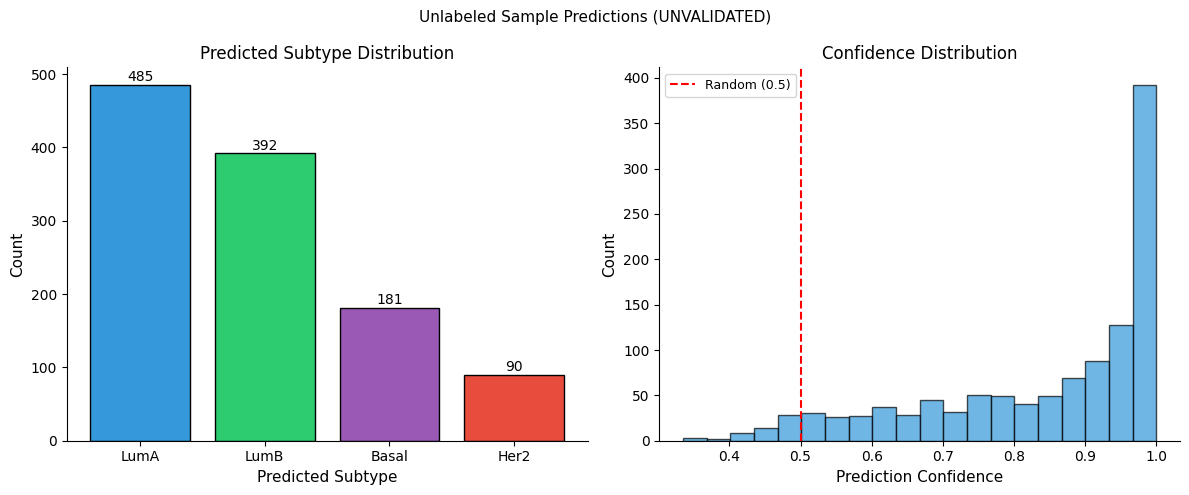

In [23]:
# Plot prediction distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

counts = predictions_df["predicted_subtype"].value_counts()
colors_bar = [PAM50_COLORS.get(st, "#888") for st in counts.index]
bars = axes[0].bar(counts.index, counts.values, color=colors_bar, edgecolor="black")
for bar, count in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(count),
                ha="center", va="bottom")
axes[0].set_xlabel("Predicted Subtype")
axes[0].set_ylabel("Count")
axes[0].set_title("Predicted Subtype Distribution")

# Confidence histogram
axes[1].hist(predictions_df["confidence"], bins=20, color="#3498db", edgecolor="black", alpha=0.7)
axes[1].axvline(0.5, color="red", linestyle="--", label="Random (0.5)")
axes[1].set_xlabel("Prediction Confidence")
axes[1].set_ylabel("Count")
axes[1].set_title("Confidence Distribution")
axes[1].legend()

fig.suptitle("Unlabeled Sample Predictions (UNVALIDATED)", fontsize=11)
fig.tight_layout()
fig.savefig(FIGURES_DIR / "05_prediction_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. High-Confidence Pseudo-Label Selection

In [24]:
print("=" * 60)
print("HIGH-CONFIDENCE PSEUDO-LABEL SELECTION")
print("=" * 60)
print(f"Criteria: top1_proba >= {PROBA_THRESHOLD}, margin >= {MARGIN_THRESHOLD}")

proba_mask = predictions_df["top1_proba"] >= PROBA_THRESHOLD
margin_mask = predictions_df["margin"] >= MARGIN_THRESHOLD
selected_mask = proba_mask & margin_mask

selected_df = predictions_df[selected_mask].copy()
n_total = len(predictions_df)
n_selected = len(selected_df)

n_failed_proba = (~proba_mask).sum()
n_failed_margin = (~margin_mask).sum()
n_failed_both = (~proba_mask & ~margin_mask).sum()

print(f"\nTotal unlabeled: {n_total}")
print(f"Selected (high-confidence): {n_selected} ({n_selected/n_total:.1%})")
print(f"Rejected: {n_total - n_selected}")
print(f"  Failed proba only: {n_failed_proba - n_failed_both}")
print(f"  Failed margin only: {n_failed_margin - n_failed_both}")
print(f"  Failed both: {n_failed_both}")

if n_selected > 0:
    print(f"\nPseudo-label distribution:")
    for st, cnt in selected_df["predicted_subtype"].value_counts().items():
        print(f"  {st}: {cnt} ({100*cnt/n_selected:.1f}%)")
    print(f"\nConfidence stats: mean={selected_df['top1_proba'].mean():.3f}, "
          f"min={selected_df['top1_proba'].min():.3f}")

HIGH-CONFIDENCE PSEUDO-LABEL SELECTION
Criteria: top1_proba >= 0.95, margin >= 0.2

Total unlabeled: 1148
Selected (high-confidence): 467 (40.7%)
Rejected: 681
  Failed proba only: 584
  Failed margin only: 0
  Failed both: 97

Pseudo-label distribution:
  LumA: 237 (50.7%)
  Basal: 134 (28.7%)
  LumB: 72 (15.4%)
  Her2: 24 (5.1%)

Confidence stats: mean=0.985, min=0.950


In [25]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
model_hash = hashlib.md5(b"ElasticNet").hexdigest()[:8]

if n_selected > 0:
    selected_df["model_name"] = "ElasticNet"
    selected_df["model_hash"] = model_hash
    selected_df["run_id"] = run_id
    selected_df["proba_threshold"] = PROBA_THRESHOLD
    selected_df["margin_threshold"] = MARGIN_THRESHOLD

    meta_cols = ["sample_id", "predicted_subtype", "top1_proba", "top2_proba", "margin",
                 "model_name", "model_hash", "run_id", "proba_threshold", "margin_threshold"]
    prob_cols = [c for c in selected_df.columns if c.startswith("prob_")]
    ordered = [c for c in meta_cols + prob_cols if c in selected_df.columns]
    selected_df = selected_df[ordered]

selected_df.to_csv(TABLES_DIR / "pseudolabels_high_confidence.csv", index=False)
print(f"Saved pseudolabels_high_confidence.csv ({n_selected} rows)")

pseudo_stats = {
    "n_total_unlabeled": int(n_total),
    "n_selected": int(n_selected),
    "n_rejected": int(n_total - n_selected),
    "selection_rate": float(n_selected / n_total) if n_total > 0 else 0,
    "proba_threshold": PROBA_THRESHOLD,
    "margin_threshold": MARGIN_THRESHOLD,
    "selected_distribution": selected_df["predicted_subtype"].value_counts().to_dict() if n_selected > 0 else {},
}

summary = {
    "run_id": run_id,
    "model_name": "ElasticNet",
    "model_hash": model_hash,
    "timestamp": datetime.now().isoformat(),
    "selection_criteria": {"proba_threshold": PROBA_THRESHOLD, "margin_threshold": MARGIN_THRESHOLD},
    "statistics": pseudo_stats,
    "warning": "PSEUDO-LABELS ARE NOT GROUND TRUTH - USE FOR EXPLORATION ONLY",
}

with open(TABLES_DIR / "pseudolabels_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print("Saved pseudolabels_summary.json")

Saved pseudolabels_high_confidence.csv (467 rows)
Saved pseudolabels_summary.json


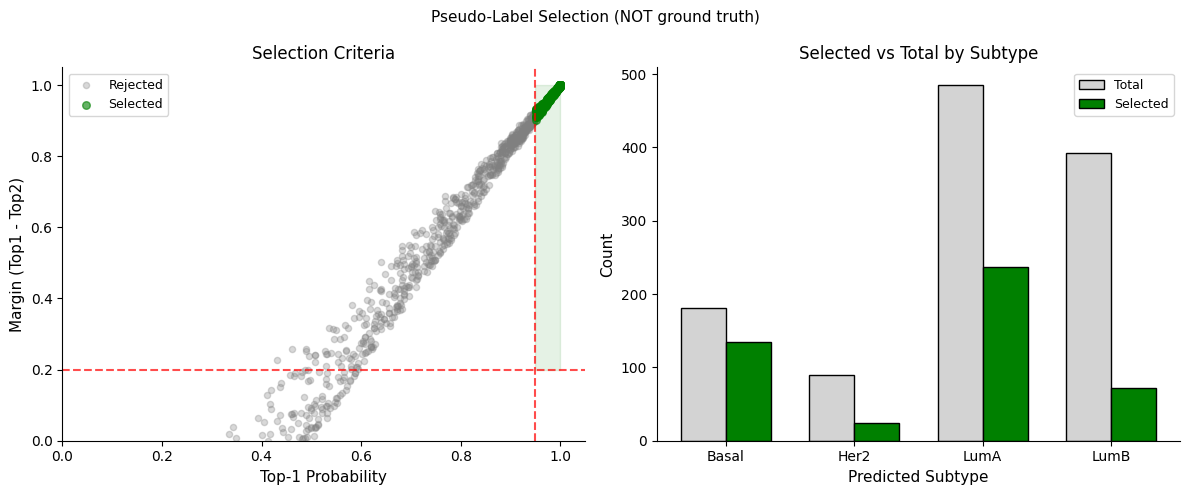

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1.scatter(predictions_df.loc[~selected_mask, "top1_proba"],
            predictions_df.loc[~selected_mask, "margin"],
            alpha=0.3, c="gray", label="Rejected", s=20)
if n_selected > 0:
    ax1.scatter(predictions_df.loc[selected_mask, "top1_proba"],
                predictions_df.loc[selected_mask, "margin"],
                alpha=0.6, c="green", label="Selected", s=30)
ax1.axvline(PROBA_THRESHOLD, color="red", linestyle="--", alpha=0.7)
ax1.axhline(MARGIN_THRESHOLD, color="red", linestyle="--", alpha=0.7)
ax1.fill_between([PROBA_THRESHOLD, 1.0], [MARGIN_THRESHOLD]*2, [1.0]*2, alpha=0.1, color="green")
ax1.set_xlabel("Top-1 Probability")
ax1.set_ylabel("Margin (Top1 - Top2)")
ax1.set_title("Selection Criteria")
ax1.legend()
ax1.set_xlim(0, 1.05)
ax1.set_ylim(0, 1.05)

# Bar: selected vs total by subtype
ax2 = axes[1]
subtypes = sorted(predictions_df["predicted_subtype"].unique())
total_c = [(predictions_df["predicted_subtype"] == st).sum() for st in subtypes]
sel_c = [selected_mask[predictions_df["predicted_subtype"] == st].sum() for st in subtypes]
x = np.arange(len(subtypes))
w = 0.35
ax2.bar(x - w/2, total_c, w, label="Total", color="lightgray", edgecolor="black")
ax2.bar(x + w/2, sel_c, w, label="Selected", color="green", edgecolor="black")
ax2.set_xticks(x)
ax2.set_xticklabels(subtypes)
ax2.set_xlabel("Predicted Subtype")
ax2.set_ylabel("Count")
ax2.set_title("Selected vs Total by Subtype")
ax2.legend()

fig.suptitle("Pseudo-Label Selection (NOT ground truth)", fontsize=11)
fig.tight_layout()
fig.savefig(FIGURES_DIR / "05_pseudolabel_selection.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Clinical Enrichment (Descriptive Only)

In [27]:
clinical_path = DATA_DIR / CLINICAL_FILE

if clinical_path.exists() and n_selected > 0:
    print("\n" + "=" * 60)
    print("CLINICAL ENRICHMENT (Descriptive Only - NOT Validation)")
    print("=" * 60)

    clinical_df = pd.read_csv(clinical_path, sep="\t", low_memory=False)
    print(f"Clinical data: {clinical_df.shape}")

    if "sample" in clinical_df.columns:
        clinical_df["sample_id_15"] = clinical_df["sample"].apply(lambda x: normalize_sample_id(x, 15))
        clinical_df["patient_id"] = clinical_df["sample"].apply(lambda x: normalize_sample_id(x, 12))

    working_df = selected_df.copy()
    working_df["_join_key"] = working_df["sample_id"].apply(lambda x: normalize_sample_id(x, 15))
    clinical_dedup = clinical_df.drop_duplicates(subset="sample_id_15", keep="first")

    enriched = working_df.merge(clinical_dedup, left_on="_join_key", right_on="sample_id_15", how="left")
    n_matched = enriched["sample_id_15"].notna().sum()
    match_rate = n_matched / len(working_df)
    print(f"  Matched: {n_matched}/{len(working_df)} ({match_rate:.1%})")

    if match_rate < 0.5:
        print("  Low match at sample level, trying patient level...")
        working_df["_join_key"] = working_df["sample_id"].apply(lambda x: normalize_sample_id(x, 12))
        clinical_dedup_p = clinical_df.drop_duplicates(subset="patient_id", keep="first")
        enriched = working_df.merge(clinical_dedup_p, left_on="_join_key", right_on="patient_id", how="left")
        n_matched = enriched["patient_id"].notna().sum()
        print(f"  Patient-level matched: {n_matched}/{len(working_df)}")

    enriched = enriched.drop(columns=["_join_key"], errors="ignore")

    stage_col = "ajcc_pathologic_stage.diagnoses"
    if stage_col in enriched.columns:
        print("\n--- Stage Distribution by Predicted Subtype ---")
        ct = pd.crosstab(enriched["predicted_subtype"], enriched[stage_col].fillna("Unknown"), margins=True)
        print(ct.to_string())
        ct.to_csv(TABLES_DIR / "pseudolabels_stage_crosstab.csv")

    age_col = "age_at_index.demographic"
    if age_col in enriched.columns:
        enriched[age_col] = pd.to_numeric(enriched[age_col], errors="coerce")
        print("\n--- Age Summary by Predicted Subtype ---")
        age_sum = enriched.groupby("predicted_subtype")[age_col].agg(["count","mean","median","std"]).round(1)
        print(age_sum.to_string())
        age_sum.to_csv(TABLES_DIR / "pseudolabels_age_summary.csv")

    enriched.to_csv(TABLES_DIR / "pseudolabels_with_clinical.csv", index=False)
    print(f"\nSaved pseudolabels_with_clinical.csv")

elif not clinical_path.exists():
    print(f"\nClinical data not found at {clinical_path}. Skipping enrichment.")
    if n_selected > 0:
        selected_df.to_csv(TABLES_DIR / "pseudolabels_with_clinical.csv", index=False)
else:
    print("\nNo pseudo-labels selected. Skipping clinical enrichment.")
    pd.DataFrame().to_csv(TABLES_DIR / "pseudolabels_with_clinical.csv", index=False)


CLINICAL ENRICHMENT (Descriptive Only - NOT Validation)
Clinical data: (1255, 85)
  Matched: 466/467 (99.8%)

--- Stage Distribution by Predicted Subtype ---
ajcc_pathologic_stage.diagnoses  Stage I  Stage IA  Stage IB  Stage II  Stage IIA  Stage IIB  Stage IIIA  Stage IIIB  Stage IIIC  Stage IV  Stage X  Unknown  All
predicted_subtype                                                                                                                                                
Basal                                  9        11         0         1         61         31          12           1           4         1        1        2  134
Her2                                   1         2         0         0         10          6           2           0           2         0        0        1   24
LumA                                  27        22         1         1         62         57          32           6          21         4        1        3  237
LumB                           

In [29]:
print("\n" + "=" * 60)
print("UNLABELED INFERENCE COMPLETE")
print("=" * 60)
print(f"\nTotal unlabeled samples: {n_total}")
print(f"Predictions saved: unlabeled_predictions.csv")
print(f"High-confidence pseudo-labels: {n_selected} ({n_selected/n_total:.1%})")
print(f"  Saved: pseudolabels_high_confidence.csv")
print(f"  Summary: pseudolabels_summary.json")
print(f"  Clinical: pseudolabels_with_clinical.csv")


UNLABELED INFERENCE COMPLETE

Total unlabeled samples: 1148
Predictions saved: unlabeled_predictions.csv
High-confidence pseudo-labels: 467 (40.7%)
  Saved: pseudolabels_high_confidence.csv
  Summary: pseudolabels_summary.json
  Clinical: pseudolabels_with_clinical.csv
